In [1]:
import numpy as np
import pandas as pd
import pickle
np.random.seed(42)
import scipy.stats as sps
import os

import matplotlib as mpl
mpl.use('Agg')
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
import matplotlib.pyplot as plt
%matplotlib inline
# print(mpl.rcParams.items)

import pylab
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fave_cmap = mpl.cm.winter_r

import proclam
from proclam import *

In [2]:
# define number of classes 
M_classes = 13
flat_factor = 1. / M_classes

# generate truth table for classes
oom = 6
generator = proclam.simulators.LogUnbalanced()
N_objects = int(10 ** oom)
minitruth = generator.simulate(M_classes, N_objects, base=oom)
pops = np.histogram(minitruth, bins=range(M_classes+1))[0]
minipops = np.empty(M_classes)
for m in range(M_classes):
    minipops[m] = np.log10(np.max((pops[m], 1.))) /np.log10(N_objects)

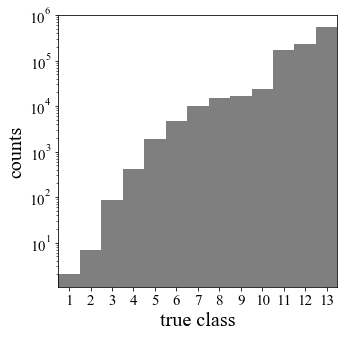

In [3]:
# make a histogram of number of counts per class

fig, ax = plt.subplots(figsize=(5, 5))
d = np.diff(np.unique(minitruth)).min()
left_of_first_bin = minitruth.min() - float(d)/2
right_of_last_bin = minitruth.max() + float(d)/2
ax.hist(minitruth, np.arange(left_of_first_bin, right_of_last_bin + d, d), log=True, alpha=0.5, color='k')
ax.set_xticks(range(M_classes))
ax.set_xticklabels(range(1, M_classes+1))
ax.set_xlim(-0.5, M_classes-0.5)
ax.set_ylabel('counts', fontsize=20)
ax.set_xlabel('true class', fontsize=20)
plt.savefig('fig/mock_counts.png')
plt.show()
plt.close()

In [4]:
# makes a confusion matrix incorporating systematic errors 

def make_cm(start_cm, m, systematic, accomplice=-1):
    cm = start_cm
    big_M = len(start_cm)
    if m < 0 or m > big_M:
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        return cm
    if systematic == 'uncertain':
        cm[m] = np.ones(big_M)
    if systematic == 'almost':
        cm[m] = flat_factor * 0.5 * np.ones(big_M)
        cm[m][m] += 1.5 * flat_factor
    if systematic == 'noisy':
        cm[m] = flat_factor * 0.5 * np.ones(big_M)
        cm[m][m] += 0.5 * flat_factor
    if systematic == 'perfect' or systematic == 'tunnel':
        cm[m] = flat_factor * np.zeros(big_M) + np.asarray(1.e-8)
        cm[:, m] = flat_factor * np.zeros(big_M).T + np.asarray(1.e-8)
        cm[m][m] += 1. * flat_factor
    if systematic == 'subsumed' or systematic == 'cruise':
        cm[m] = cm[accomplice]
    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    return cm

In [5]:
classifier = proclam.classifiers.FromCM()

mega_test, alt_mega_test = {}, {}
N_affected = range(M_classes)

delfact = -1
minidelta = 10**delfact
altdelfact = delfact * 2
altminidelta = 10**altdelfact

metric_info = {'LogLoss': mpl.cm.winter_r(1.), 'ROCAUC': mpl.cm.winter_r(0.)}
which_metrics = metric_info.keys()
met_evals = {}
for met in which_metrics:
    met_evals[met] = getattr(proclam.metrics, met)()

In [6]:
# setup shapes for each systematic + background and foreground colors
all_shapes = {'uncertain':'s', 'tunnel':'o', 'almost':'P', 'noisy':'X', 'subsumed': 'D', 'perfect': '*'}
all_shapes_bg = {'perfect':(3,0,0), 'almost':(4,0,0), 'noisy':(4,0,45)}
all_shapes_fg = {'uncertain':'.', 'almost':(4,2,0), 'noisy':(4,2,45), 'subsumed':(3,2,180)}

In [7]:
possible_weights = np.linspace(0., 1., 11)
weight_vecs = np.array([[i] + [(1. - i) / (M_classes - 1.)] * (M_classes - 1) for i in possible_weights])
which_weight_schemes = {str(i): weight_vecs[i] for i in range(len(possible_weights))}
fave_cmap = mpl.cm.winter_r

In [8]:
def cm_mega_plot(info_dict, systematics, m, fn='', numrows=2, numcols=4):
    fig = pylab.figure(figsize=(5.1, 5.1))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    bigAxes.set_title(fn+' with '+str(m)+' affected')
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(numrows,numcols),
                 axes_pad=0.,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.01,
                 )
    gridnos = np.arange(numrows * numcols).reshape((numcols, numrows)).T.flatten()
    for j in range(numcols * numrows):
        i = gridnos[j]
        ax = grid[j]#fig.add_subplot(numrows,numcols,i+1)#, frameon=False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        position = ax.get_position()

        position.x0 += 0.01
        position.y0 += 0.02
        position.x1 += 0.01
        position.y1 += 0.02
        ax.set_position(position)
        testname = systematics[j]
        
        im = ax.imshow(info_dict[testname]['cm'][m], vmin=0., vmax=1., cmap='winter_r')
        ax.text(.5,.9,testname,horizontalalignment='center',transform=ax.transAxes, fontsize=16)

    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)
    bigAxes.set_ylabel(r'true class', fontsize=20)
    bigAxes.set_xlabel(r'predicted class', fontsize=20)
    pylab.tight_layout()
    pylab.savefig('fig/systest_'+fn+'_cm.png', bbox_inches='tight', pad_inches=0)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


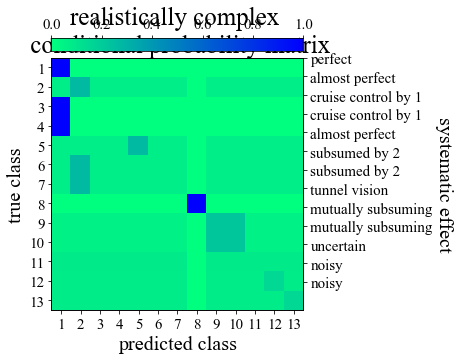

In [9]:
starter = 0.5 * np.ones((M_classes, M_classes)) + 1.5 * np.eye(M_classes)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
cm = starter


cruise = [0, 1]#afflicted[2:4]
subsumed = [2, 3, 5, 6]#afflicted[4:8]
swapped = [-4, -5]
tunnel = [0, 7]#afflicted[8:]
noisy_cls = [-2, -1]#afflicted[:2]
uncertain = [-3]
afflicted = cruise + subsumed + tunnel + noisy_cls

systematic_types = [
    'perfect',
    'almost perfect',
    'cruise control by 1',
    'cruise control by 1',
    'almost perfect',
    'subsumed by 2',
    'subsumed by 2',
    'tunnel vision',
    'mutually subsuming',
    'mutually subsuming',
    'uncertain',
    'noisy',
    'noisy'
]
plot_systematic_types = list(reversed(systematic_types))

almost = 0.5 * np.ones((M_classes, M_classes)) + 1.5 * np.eye(M_classes)
almost = almost / np.sum(almost, axis=1)[:, np.newaxis]
cm = almost
perfect = np.eye(M_classes) + 1.e-8
cm[tunnel] = perfect[tunnel]
noisy = 0.5 * np.ones((M_classes, M_classes)) + 0.5 * np.eye(M_classes)
noisy = noisy / np.sum(starter, axis=1)[:, np.newaxis]
cm[noisy_cls] = noisy[noisy_cls]
cm[subsumed[:2]] = cm[cruise[0]]#[np.newaxis] + np.asarray(0.01)[np.newaxis] * np.random.uniform(M_classes)[np.newaxis, :]
cm[subsumed[2:]] = cm[cruise[1]]
cm[uncertain] = 1./float(M_classes) * np.ones(M_classes)
cm[swapped[1]][swapped[0]] = cm[swapped[0]][swapped[0]]
cm[swapped[0]][swapped[1]] = cm[swapped[1]][swapped[1]]
cm[:, 7] = perfect[:, 7]

cm = cm / np.sum(cm, axis=1)[:, np.newaxis]

print(np.sum(cm, axis=1))

fig = plt.figure(figsize=(5,5))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,1),
                 axes_pad=0.,
                 share_all=True,
                 cbar_location="top",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.1,
                 )
ax = grid[0]
im = ax.imshow(cm, vmin=0., vmax=1., cmap=mpl.cm.winter_r)
ax.set_xticks(range(M_classes))
ax.set_xticklabels(range(1, M_classes+1))
ax.set_yticks(range(M_classes))
ax.set_yticklabels(range(1, M_classes+1))

ax.set_ylabel('true class')
ax.set_xlabel('predicted class')
axp = ax.twinx()
axp.set_ylim(-0.5, M_classes-0.5)
axp.set_yticks(range(1, M_classes+1))
axp.set_yticklabels(plot_systematic_types)
# plt.colorbar(thing, orientation='horizontal') 
axp.set_ylabel('systematic effect', rotation=270, labelpad=20)
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
ax.set_title('realistically complex \n conditional probability matrix')
plt.savefig('fig/combined.png')
plt.show()
plt.close()

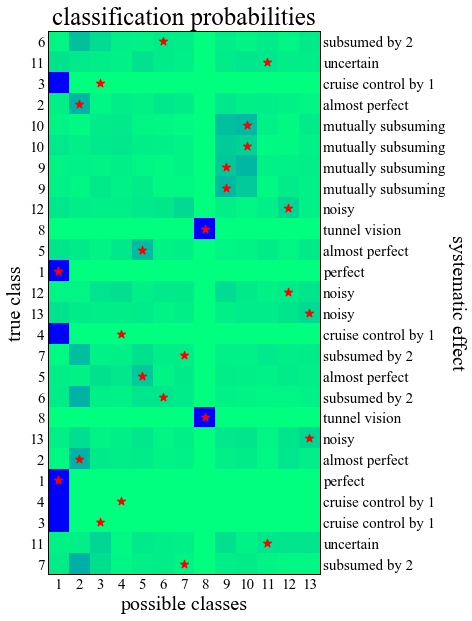

In [10]:
import random
from mpl_toolkits.axes_grid1 import ImageGrid

howmanytoshow = 2 * M_classes
truth_here = list(range(M_classes))+list(range(M_classes))#np.random.choice(M_classes, howmanytoshow)
random.shuffle(truth_here)
truth_here = np.array(truth_here)

classifier = FromCMDM()
res = classifier.classify(cm, truth_here, delta=0.01, other=False)

tickinfo = [systematic_types[i] for i in truth_here]
tickinfo = list(reversed(tickinfo))

fig = plt.figure(figsize=(5,10))
axs = ImageGrid(fig, 111, nrows_ncols=(1,1))
ax = axs[0]
ax.set_title('classification probabilities')
ax.set_xlabel('possible classes')
ax.set_xticks(range(M_classes))
ax.set_xticklabels(range(1, M_classes+1))

ax.imshow(res, vmin=0., vmax=1., cmap=mpl.cm.winter_r)
ax.set_yticks(range(howmanytoshow))
ax.set_yticklabels(truth_here+1)
ax.set_ylabel('true class')
ax.tick_params(axis=u'both', which=u'both',length=0)
for x, y in zip(truth_here, range(howmanytoshow)):
    ax.scatter(x, y, marker='*', color="red", s=75)#, fontsize=15)

ax2 = ax.twinx()
ax2.set_yticks(range(howmanytoshow))
ax2.set_yticklabels(tickinfo)
ax2.set_ylabel('systematic effect', rotation=270, labelpad=20)
ax2.set_ylim(-0.5, howmanytoshow-0.5)
ax2.tick_params(axis=u'both', which=u'both',length=0)

plt.savefig('fig/examples.png', dpi=250)
plt.show()

# test number affected by each systematic relative to different baselines

In [11]:
def one_loop_naff(collector, name, which_systematics, starter, dirichlet=False, fn=None):# mega_test, 'reltoagnostic'
    systest = {}
    if not dirichlet:
        classifier = FromCM()
        delta = minidelta
    else:
        classifier = FromCMDM()
        delta = altminidelta
    print('dirichlet='+str(dirichlet)+', delta='+str(delta))
    for s in which_systematics:

        systest[s] = {}
        for met in which_metrics:
            systest[s][met] = {}
            for w in which_weight_schemes:
                systest[s][met][w] = np.empty(M_classes+1)
        m = -1
        temp_cm = starter
        systest[s]['cm'] = np.empty((M_classes+1, M_classes, M_classes))
        temp_prob = classifier.classify(temp_cm, minitruth, delta=delta, other=False)

        isolated = range(N_objects)
        while m < M_classes:
            temp_cm = make_cm(temp_cm, m, s)
            systest[s]['cm'][m+1] = temp_cm
            temp_prob[isolated] = classifier.classify(temp_cm, minitruth[isolated], delta=delta, other=False)

            for met in which_metrics:
                D = met_evals[met]
                if met != 'ROCAUC':
                    for w in which_weight_schemes.keys():
                        metval = D.evaluate(temp_prob, minitruth, averaging=which_weight_schemes[w])
                        systest[s][met][w][m+1] = metval
                else:
                    metval = D.evaluate(temp_prob, sklearn_truth)
                    for w in which_weight_schemes.keys():
                        systest[s][met][w][m+1] = metval
                    
            thingtoprint = np.sum(np.ones(N_objects)[np.argmax(temp_prob, axis=1) == minitruth])
            print('how many would be right by MAP with systematic '+s+' and '+str(m+1)+' affected classes? '+
                    str(thingtoprint)+' or '+str(thingtoprint/float(N_objects)))
            m += 1
            isolated = np.where(minitruth == m)[0]

    collector[name] = systest
    if fn is not None:
        with open(fn, 'wb') as place:
            pickle.dump(collector, place)
    return collector

In [12]:
def load_collector(fn):
    with open(fn, 'rb') as place:
        collector = pickle.load(place)
    return collector

### Dirichlet perturbation

In [13]:
M_classes = 2
flat_factor = 1. / M_classes

oom = 6
generator = proclam.simulators.LogUnbalanced()
N_objects = int(10 ** oom)
minitruth = generator.simulate(M_classes, N_objects, base=oom)

sklearn_truth = np.zeros((N_objects, M_classes))
for i, x in enumerate(minitruth):
    sklearn_truth[i][minitruth[i]] = 1.

pops = np.histogram(minitruth, bins=range(M_classes+1))[0]
minipops = np.empty(M_classes)
for m in range(M_classes):
    minipops[m] = np.log10(np.max((pops[m], 1.))) /np.log10(N_objects)

possible_weights = np.linspace(0., 1., 11)
weight_vecs = np.array([[i] + [(1. - i) / (M_classes - 1.)] * (M_classes - 1) for i in possible_weights])
which_weight_schemes = {str(i): weight_vecs[i] for i in range(len(possible_weights))}

fave_cmap = mpl.cm.winter_r

infile = 'fig/test'+str(M_classes)+'_fromcmdm.pkl'
if os.path.exists(infile):
    alt_mega_test = load_collector('fig/test'+str(M_classes)+'_fromcmdm.pkl')

## isolating the systematics with flat weights, relative to perfect

In [14]:
which_systematics = ['almost', 'noisy', 'uncertain', 'subsumed']
starter = np.eye(M_classes) + np.asarray(1.e-8)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
alt_mega_test = one_loop_naff(alt_mega_test, 'perfect', which_systematics, starter, dirichlet=True, fn='fig/test'+str(M_classes)+'_fromcmdm.pkl')

dirichlet=True, delta=0.01
how many would be right by MAP with systematic almost and 0 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic almost and 1 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic almost and 2 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic noisy and 0 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic noisy and 1 affected classes? 999835.0 or 0.999835
how many would be right by MAP with systematic noisy and 2 affected classes? 999617.0 or 0.999617
how many would be right by MAP with systematic uncertain and 0 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic uncertain and 1 affected classes? 786858.0 or 0.786858
how many would be right by MAP with systematic uncertain and 2 affected classes? 499486.0 or 0.499486
how many would be right by MAP with systematic subsumed and 0 affected classes? 1000000.0 or 1.0

## isolating the systematics with flat weights, relative to almost perfect

In [15]:
which_systematics = ['noisy', 'uncertain', 'subsumed']#['tunnel', 'noisy', 'uncertain', 'subsumed']
starter = 0.5 * np.ones((M_classes, M_classes)) + 1.5 * np.eye(M_classes)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
alt_mega_test = one_loop_naff(alt_mega_test, 'almost', which_systematics, starter, dirichlet=True, fn='fig/test'+str(M_classes)+'_fromcmdm.pkl')

dirichlet=True, delta=0.01
how many would be right by MAP with systematic noisy and 0 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic noisy and 1 affected classes? 999837.0 or 0.999837
how many would be right by MAP with systematic noisy and 2 affected classes? 999634.0 or 0.999634
how many would be right by MAP with systematic uncertain and 0 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic uncertain and 1 affected classes? 787171.0 or 0.787171
how many would be right by MAP with systematic uncertain and 2 affected classes? 500475.0 or 0.500475
how many would be right by MAP with systematic subsumed and 0 affected classes? 1000000.0 or 1.0
how many would be right by MAP with systematic subsumed and 1 affected classes? 574659.0 or 0.574659
how many would be right by MAP with systematic subsumed and 2 affected classes? 574659.0 or 0.574659


## isolating the systematics with flat weights, relative to noisy

In [16]:
which_systematics = ['uncertain', 'subsumed']#['tunnel', 'almost', 'uncertain', 'subsumed']
starter = 0.5 * np.ones((M_classes, M_classes)) + 0.5 * np.eye(M_classes)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
alt_mega_test = one_loop_naff(alt_mega_test, 'noisy', which_systematics, starter, dirichlet=True, fn='fig/test'+str(M_classes)+'_fromcmdm.pkl')

dirichlet=True, delta=0.01
how many would be right by MAP with systematic uncertain and 0 affected classes? 999646.0 or 0.999646
how many would be right by MAP with systematic uncertain and 1 affected classes? 787545.0 or 0.787545
how many would be right by MAP with systematic uncertain and 2 affected classes? 500726.0 or 0.500726
how many would be right by MAP with systematic subsumed and 0 affected classes? 999619.0 or 0.999619
how many would be right by MAP with systematic subsumed and 1 affected classes? 574588.0 or 0.574588
how many would be right by MAP with systematic subsumed and 2 affected classes? 574599.0 or 0.574599


## isolating the systematics with flat weights, relative to uncertain

In [17]:
which_systematics = ['subsumed']#, 'tunnel']
starter = np.ones((M_classes, M_classes)) + 1.e-8
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
alt_mega_test = one_loop_naff(alt_mega_test, 'uncertain', which_systematics, starter, dirichlet=True, fn='fig/test'+str(M_classes)+'_fromcmdm.pkl')

dirichlet=True, delta=0.01
how many would be right by MAP with systematic subsumed and 0 affected classes? 499687.0 or 0.499687
how many would be right by MAP with systematic subsumed and 1 affected classes? 500247.0 or 0.500247
how many would be right by MAP with systematic subsumed and 2 affected classes? 500738.0 or 0.500738


## Revamping this summary plot for new results

In [ ]:
possible_weights = np.linspace(0., 1., 11)
weight_vecs = np.array([[i] + [(1. - i) / (M_classes - 1.)] * (M_classes - 1) for i in possible_weights])
which_weight_schemes = {str(i): weight_vecs[i] for i in range(len(possible_weights))}

fave_cmap = mpl.cm.winter_r
all_shapes = {'uncertain':'s', 'tunnel':'o', 'almost':'P', 'noisy':'X', 'subsumed': 'D', 'perfect': '*'}
all_shapes_bg = {'perfect':(3,0,0), 'almost':(4,0,0), 'noisy':(4,0,45)}#, 'cruise':(3,0,180)}
all_shapes_fg = {'uncertain':'.', 'almost':(4,2,0), 'noisy':(4,2,45), 'subsumed':(3,2,180)}#, 'tunnel':(3,2,0)

alt_mega_test = load_collector('fig/test2_fromcmdm.pkl')

In [19]:
alt_mega_test

{'perfect': {'almost': {'LogLoss': {'0': array([1.77747456e-08, 1.77747456e-08, 2.24250695e-01]),
    '1': array([2.27668220e-08, 2.24309263e-02, 2.24256536e-01]),
    '2': array([2.77588984e-08, 4.48618347e-02, 2.24262376e-01]),
    '3': array([3.27509748e-08, 6.72927432e-02, 2.24268217e-01]),
    '4': array([3.77430512e-08, 8.97236517e-02, 2.24274058e-01]),
    '5': array([4.27351276e-08, 1.12154560e-01, 2.24279899e-01]),
    '6': array([4.77272040e-08, 1.34585469e-01, 2.24285740e-01]),
    '7': array([5.27192804e-08, 1.57016377e-01, 2.24291580e-01]),
    '8': array([5.77113568e-08, 1.79447286e-01, 2.24297421e-01]),
    '9': array([6.27034332e-08, 2.01878194e-01, 2.24303262e-01]),
    '10': array([6.76955096e-08, 2.24309103e-01, 2.24309103e-01])},
   'ROCAUC': {'0': array([1., 1., 1.]),
    '1': array([1., 1., 1.]),
    '2': array([1., 1., 1.]),
    '3': array([1., 1., 1.]),
    '4': array([1., 1., 1.]),
    '5': array([1., 1., 1.]),
    '6': array([1., 1., 1.]),
    '7': array([1., 

In [20]:
minimal_data = {i:alt_mega_test[i] for i in alt_mega_test if (i!='delta' and i!='subsumed')}

In [21]:
upper_data = {i:minimal_data[i] for i in minimal_data if i=='perfect'}
middle_data = {i:minimal_data[i] for i in minimal_data if i!='perfect'}
lower_data = {i:minimal_data[i] for i in minimal_data if (i!='cruise' and i!='uncertain')}
for base in lower_data.keys():
    lower_data[base] = {i:lower_data[base][i] for i in lower_data[base] if i!='subsumed'}
for base in middle_data.keys():
    middle_data[base] = {i:middle_data[base][i] for i in middle_data[base] if i=='subsumed'}
for base in upper_data.keys():
    upper_data[base] = {i:upper_data[base][i] for i in upper_data[base] if i=='subsumed'}

In [22]:
def complete_metric_plot(dataset, metric_names, xlims=None, ylims=None, fn='test_combo'):
    
    fig, ax = plt.subplots(figsize=(5,5))
    fig.subplots_adjust(right=1.)

    bases, additions = [], []
    for base in dataset.keys():# this is the base upon which a systematic was added
        if base != 'uncertain':
            bases.append(base)
            for added in dataset[base].keys():# this is the systematic added on
                additions.append(added)
                xvals = [dataset[base][added][metric_names[0]][str(i)][1] for i in range(11)]
                yvals = [dataset[base][added][metric_names[1]][str(i)][1] for i in range(11)]
                ax.scatter(xvals, yvals,
                  c=fave_cmap(np.flip(possible_weights)),
                  s=100.,
                  marker=all_shapes_bg[base],
                  alpha=0.25)
                ax.scatter(xvals, yvals,
                  c=fave_cmap(possible_weights),
                  marker=all_shapes_fg[added],
                  alpha=0.5)

    bases = list(set(bases))
    additions = list(set(additions))
    b_handles, a_handles = [], []
    for base in bases:
        if base != 'uncertain':
            thing = plt.scatter(-1., -1., label=base, color='k', alpha=0.25, marker=all_shapes_bg[base])
            b_handles.append(thing)
    bg_legend = plt.legend(handles=b_handles, loc='upper left')
    for added in additions:
        thing = plt.scatter(-1., -1., label=added, color='k', alpha=0.75, marker=all_shapes_fg[added])
        a_handles.append(thing)
    lax = plt.gca().add_artist(bg_legend)
    plt.legend(handles=a_handles, loc='lower right', fontsize='large')

    ax.set_xlabel(metric_names[0])
    ax.set_ylabel(metric_names[1])
    if xlims is not None:
        ax.set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        ax.set_ylim(ylims[0], ylims[1])
    ax.semilogx()
    ax.semilogy()

    cax = fig.add_axes([1., 0.125, 0.05, 0.745])#([0.05, 0.80, 0.9, 0.15])
    cb = mpl.colorbar.ColorbarBase(cax, cmap=fave_cmap,
                                norm=mpl.colors.Normalize(vmin=0., vmax=1.),
                                orientation='vertical')
    cb.set_label('Fractional Weight', rotation=270, labelpad=15.)
    plt.subplots_adjust()
    plt.savefig('fig/'+fn+'.png')
    plt.show()
    plt.close()
    return

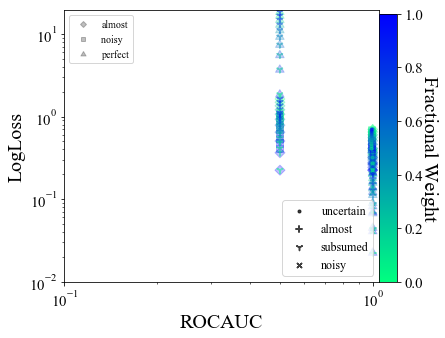

In [23]:
complete_metric_plot(minimal_data, ['ROCAUC', 'LogLoss'], fn='all', xlims=(1.e-1, 1.05), ylims=(1.e-2, 19.5))

In [24]:
complete_metric_plot(upper_data, ['ROCAUC', 'LogLoss'], fn='upper_zoom', xlims=(0., 1.05), ylims=(0., 19.5))

ValueError: posx and posy should be finite values

ValueError: posx and posy should be finite values

In [ ]:
complete_metric_plot(middle_data, ['ROCAUC', 'LogLoss'], fn='middle_zoom', xlims=(0., 0.675), ylims=(0., 1.75))

In [ ]:
complete_metric_plot(lower_data, ['ROCAUC', 'LogLoss'], fn='lower_zoom', xlims=(0., 0.275), ylims=(0., 0.75))

In [25]:
alt_mega_test = load_collector('fig/test2_fromcmdm.pkl')

In [26]:
for base in alt_mega_test.keys():
    for added in alt_mega_test[base].keys():
        numerator = alt_mega_test[base][added]['LogLoss']['10'][1] - alt_mega_test[base][added]['LogLoss']['0'][1]
        denominator = alt_mega_test[base][added]['ROCAUC']['10'][1] - alt_mega_test[base][added]['ROCAUC']['0'][1]
        minx = round(alt_mega_test[base][added]['ROCAUC']['0'][1], 4)
        miny = round(alt_mega_test[base][added]['LogLoss']['0'][1], 4)
        maxx = round(alt_mega_test[base][added]['ROCAUC']['10'][1], 4)
        maxy = round(alt_mega_test[base][added]['LogLoss']['10'][1], 4)
        minimum = (minx, miny)
        maximum = (maxx, maxy)
        print(base+' plus '+added)
        print('slope = '+str(round(numerator / denominator, 4)))
        print('extrema = '+str((minimum, maximum)))

perfect plus almost
slope = inf
extrema = ((1.0, 0.0), (1.0, 0.2243))
perfect plus noisy
slope = inf
extrema = ((1.0, 0.0), (1.0, 0.4082))
perfect plus uncertain
slope = inf
extrema = ((1.0, 0.0), (1.0, 0.6983))
perfect plus subsumed
slope = inf
extrema = ((0.5, 0.0), (0.5, 18.4206))
almost plus noisy
slope = inf
extrema = ((1.0, 0.2245), (1.0, 0.4078))
almost plus uncertain
slope = inf
extrema = ((1.0, 0.2244), (1.0, 0.6982))
almost plus subsumed
slope = inf
extrema = ((0.5005, 0.2243), (0.5005, 1.6296))
noisy plus uncertain
slope = inf
extrema = ((0.992, 0.4081), (0.992, 0.6982))
noisy plus subsumed
slope = inf
extrema = ((0.4998, 0.4082), (0.4998, 1.1084))
uncertain plus subsumed
slope = inf
extrema = ((0.5002, 0.6982), (0.5002, 0.6982))


/Users/gnarayan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


In [27]:
order = ['upper', 'middle', 'lower']
lims = {}
lims['upper'] = (1.05, 19.5)
lims['middle'] = (0.675, 1.75)
lims['lower'] = (0.275, 0.75)
lims['all'] = (1.1, 20.)
boxcols = {}
boxcols['lower'] = '#D179F2'
boxcols['middle'] = '#F27979'
boxcols['upper'] = '#FFE17F'
boxcols['all'] = 'None'
multiscaledata = {}
multiscaledata['all'] = minimal_data
multiscaledata['upper'] = upper_data
multiscaledata['middle'] = middle_data
multiscaledata['lower'] = lower_data
titles = {}
titles['upper'] = 'subsumed systematic on perfect baseline'
titles['middle'] = 'subsumed systematic on non-perfect baselines'
titles['lower'] = 'non-subsumed systematics on all baselines'

In [28]:
def paneled_metric_plot(full_dataset, metric_names, order, lims, boxcols, titles, fn='multipanel_res'):

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset

    fig = pylab.figure(figsize=(17.5, 5))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    bigAxes.set_xlabel(metric_names[0], fontsize=20, labelpad=25)
    bigAxes.set_ylabel(metric_names[1], fontsize=20, labelpad=30)
    
    axupper = fig.add_subplot(131)
    
    axmiddle = inset_axes(axupper, width="100%", height="100%",
                   bbox_to_anchor=(1.10, 0., 1., 1.),
                   bbox_transform=axupper.transAxes, loc=2, borderpad=0)
    axmiddle.tick_params(left=True, right=False, labelleft=True, labelright=False)
    mark_inset(axupper, axmiddle, loc1=2, loc2=3, fc="none", ec="0.5")
    
    axlower = inset_axes(axmiddle, width="100%", height="100%",
                   bbox_to_anchor=(1.10, 0., 1., 1.),
                   bbox_transform=axmiddle.transAxes, loc=2, borderpad=0)
    axlower.tick_params(left=True, right=False, labelleft=True, labelright=False)
    mark_inset(axmiddle, axlower, loc1=2, loc2=3, fc="none", ec="0.5")
    
    # make a list of these axes
    # copy the loop from below
    
    allmyaxes = [axupper, axmiddle, axlower]
    
    for i in range(3):
        scale = order[i]
        ax = allmyaxes[i]
    
        dataset = full_dataset[scale]
        
        xlims = (-0.1 * lims[scale][0], lims[scale][0])
        ylims = (-0.1 * lims[scale][1], lims[scale][1])

        bases, additions = [], []
        for base in dataset.keys():# this is the base upon which a systematic was added
            if base != 'uncertain':
                bases.append(base + ' as baseline')
                for added in dataset[base].keys():# this is the systematic added on
                    additions.append(added + ' as systematic')
                    xvals = [dataset[base][added][metric_names[0]][str(i)][1] for i in range(11)]
                    yvals = [dataset[base][added][metric_names[1]][str(i)][1] for i in range(11)]
                    ax.scatter(xvals, yvals,
                      c=fave_cmap(np.flip(possible_weights)),
                      s=150.,
                      marker=all_shapes_bg[base],
                      alpha=0.25)
                    ax.scatter(xvals, yvals,
                      c=fave_cmap(possible_weights),
                      s=125.,
#                   s=100.*miniweights[wi][m],
                      marker=all_shapes_fg[added],
                      alpha=0.5)
        ax.set_title(titles[order[i]], fontsize=17.5)
        bases = list(set(bases))
        additions = list(set(additions))
        all_labels = bases+additions
        b_handles, a_handles = [], []
        for base in bases:
            thing = ax.scatter(-1., -1., label=base, color='k', alpha=0.25, marker=all_shapes_bg[base[:-12]])
            b_handles.append(thing)
#         bg_legend = ax.legend(handles=b_handles, loc='upper left', fontsize='large')
        for added in additions:
            thing = ax.scatter(-1., -1., label=added, color='k', alpha=0.75, marker=all_shapes_fg[added[:-14]])
            a_handles.append(thing)
#         lax = plt.gca().add_artist(bg_legend)
#         fg_legend = ax.legend(handles=a_handles, loc='lower right', fontsize='large')
        if i != 2:
            ax.legend(handles=b_handles+a_handles, loc='upper left', fontsize='large')
        else:
            axins = inset_axes(ax,
                    width="2%",  # width = 25% of parent_bbox width
                    height="90%",  # height : 5%
                    loc=4)
            mpl.colorbar.ColorbarBase(axins, cmap=fave_cmap,
                                norm=mpl.colors.Normalize(vmin=0., vmax=1.))
#             axins.xaxis.set_ticks_position("left")
#     axins.xaxis.set_ticks(np.flip(seeds, axis=0))
#             axins.xaxis.set_ticklabels([]) #rotation=270, fontsize=10)

#     cax = fig.add_axes([1., 0.125, 0.05, 0.745])#([0.05, 0.80, 0.9, 0.15])
#     cb = mpl.colorbar.ColorbarBase(cax, cmap=fave_cmap,
#                                 norm=mpl.colors.Normalize(vmin=0., vmax=1.),
#                                 orientation='vertical')
            axins.set_ylabel('Fractional Weight', rotation=270, labelpad=15., fontsize=15.)
            ax.legend(handles=b_handles+a_handles, loc='lower right', fontsize='large')
        if xlims is not None:
            ax.set_xlim(xlims[0], xlims[1])
        if ylims is not None:
            ax.set_ylim(ylims[0], ylims[1])
            
    plt.subplots_adjust()

#     fig.tight_layout()
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    pylab.savefig('fig/'+fn+'.png', dpi=250)
    pylab.show()
    return

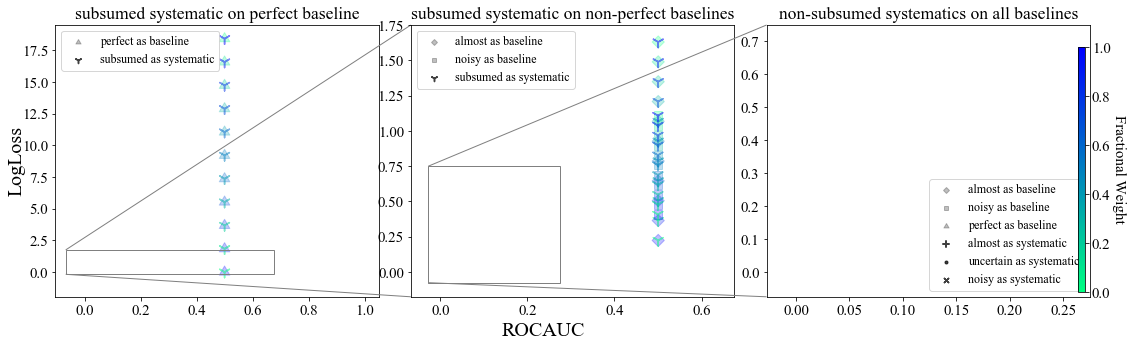

In [29]:
paneled_metric_plot(multiscaledata, ['ROCAUC', 'LogLoss'], order, lims, boxcols, titles, fn='multipanel_res')

In [ ]:
def paneled_metric_plot(full_dataset, metric_names, order, lims, boxcols, fn='multipanel_res'):
    
    fig = pylab.figure(figsize=(10, 10))
#     fig = pylab.figure(figsize=(10.2, 10.))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    bigAxes.set_xlabel(metric_names[0], fontsize=20, labelpad=25)
    bigAxes.set_ylabel(metric_names[1], fontsize=20, labelpad=25)
    
    for i in range(4):
        scale = order[i]
        ax = fig.add_subplot(2, 2, i+1)
    
        dataset = full_dataset[scale]
        
        xlims = (0, lims[scale][0])
        ylims = (0, lims[scale][1])
        
        for o in order[1:]:
            if lims[scale][0] > lims[o][0] and lims[scale][1] > lims[o][1]:
                ax.fill_between([0., lims[o][0]], 0., lims[o][1], color=boxcols[o], alpha=0.2)
    
#     systematics = dataset.keys()
#     xs = np.arange(len(systematics))
#     fig, ax = plt.subplots(figsize=(5,5))
    
#     ax.text(.3, .95, r'color$\sim w_{m}$', 
#             verticalalignment='center', transform=ax.transAxes, 
#             fontsize=10)
#     ax.text(.3, .9, r'size$\sim w_{m}$', 
#             verticalalignment='center', transform=ax.transAxes, 
#             fontsize=10)
#     fig.subplots_adjust(right=1.)
#     handles = []
#     seeds = []
        bases, additions = [], []
        for base in dataset.keys():# this is the base upon which a systematic was added
            if base != 'uncertain':
                bases.append(base)
                for added in dataset[base].keys():# this is the systematic added on
                    additions.append(added)
                    xvals = [dataset[base][added][metric_names[0]][str(i)][1] for i in range(11)]
                    yvals = [dataset[base][added][metric_names[1]][str(i)][1] for i in range(11)]
                    ax.scatter(xvals, yvals,
                      c=fave_cmap(np.flip(possible_weights)),
                      s=100.,
                      marker=all_shapes_bg[base],
                      alpha=0.25)
                    ax.scatter(xvals, yvals,
                      c=fave_cmap(possible_weights),
#                   s=100.*miniweights[wi][m],
                      marker=all_shapes_fg[added],
                      alpha=0.5)
#     for m in which_affected:
#         one_seed = np.log10(max(1., N_objects * float(minipops[m]))) / 10.
#         seeds.append(one_seed)
#         for si in range(len(systematics)):
#             s = systematics[si]
#             for i in range(len(which_weighted)):
#                 w = which_weighted[wi]
# #                 rel_wt = (np.average(miniweights[wi][m]) - miniweights[wi][m][m]) / np.average(miniweights[wi][m]) / 2. + 0.5
# #                 print(rel_wt)
#                 ax.scatter(dataset[s][str(m)][metric_names[0]][w], dataset[s][str(m)][metric_names[1]][w],
#                   c=mpl.cm.winter_r(possible_weights[i]),
#                   s=100.*miniweights[wi][m],
#                   marker=markerlist[si],
#                   alpha=0.25)
#     for si in range(len(systematics)):
#         ax.scatter(0., 0., c='k',
#                   marker=markerlist[si],
#                   alpha=0.25, label=systematics[si])
        bases = list(set(bases))
        additions = list(set(additions))
        b_handles, a_handles = [], []
        for base in bases:
            thing = plt.scatter(-1., -1., label=base, color='k', alpha=0.25, marker=all_shapes_bg[base])
            b_handles.append(thing)
        bg_legend = plt.legend(handles=b_handles, loc='upper left', fontsize='large')
        if i > 0:
            frame = bg_legend.get_frame()
            frame.set_alpha(0.2)
            frame.set_facecolor(boxcols[scale])
        for added in additions:
            thing = plt.scatter(-1., -1., label=added, color='k', alpha=0.75, marker=all_shapes_fg[added])
            a_handles.append(thing)
        lax = plt.gca().add_artist(bg_legend)
        fg_legend = plt.legend(handles=a_handles, loc='lower right', fontsize='large')
        if i > 0:
            frame = fg_legend.get_frame()
            frame.set_alpha(0.2)
            frame.set_facecolor(boxcols[scale])
#         ax.set_xlabel(metric_names[0])
#         ax.set_ylabel(metric_names[1])
        if xlims is not None:
            ax.set_xlim(xlims[0], xlims[1])
        if ylims is not None:
            ax.set_ylim(ylims[0], ylims[1])
        if i%2 == 1:
            ax.yaxis.tick_right()
        if i < 2:
            ax.xaxis.tick_top()
        if i == 1: 
#             ax.set_yticklabels([])
            
#     ax.semilogx()
#     ax.semilogy()
#     ax.legend(loc='lower right')
    
#     seeds = np.array(seeds)
#     print(seeds)
            axins = inset_axes(ax,
                    width="5%",  # width = 25% of parent_bbox width
                    height="75%",  # height : 5%
                    loc=6)
            mpl.colorbar.ColorbarBase(axins, cmap=fave_cmap,
                                norm=mpl.colors.Normalize(vmin=0., vmax=1.))
#             axins.xaxis.set_ticks_position("left")
#     axins.xaxis.set_ticks(np.flip(seeds, axis=0))
            axins.xaxis.set_ticklabels([]) #rotation=270, fontsize=10)

#     cax = fig.add_axes([1., 0.125, 0.05, 0.745])#([0.05, 0.80, 0.9, 0.15])
#     cb = mpl.colorbar.ColorbarBase(cax, cmap=fave_cmap,
#                                 norm=mpl.colors.Normalize(vmin=0., vmax=1.),
#                                 orientation='vertical')
            axins.set_ylabel('Fractional Weight', rotation=270, labelpad=15., fontsize=15.)
    plt.subplots_adjust()

#     fig.tight_layout()
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    pylab.savefig('fig/'+fn+'.png', dpi=250)
    pylab.show()
    return

# Propagating Dirichlet change: not done past here

# same thing, but as a function of the weight on that class rather than number of classes affected

note, specifying class 6 because of weird behavior when there are no true class members

In [ ]:
relwttest = {}
abswttest = {}
only_weight = 0

weight_choices = {}
big_W = {}

weight_choices['rel'] = np.arange(0., 2.25, 0.25)
big_W['rel'] = len(weight_choices['rel'])

weight_choices['abs'] = np.arange(0., 1.1, 0.1)
big_W['abs'] = len(weight_choices['abs'])

wts = {}
wts['rel'] = np.ones((big_W['rel'], M_classes))
for wi in range(big_W['rel']):
    wts['rel'][wi][only_weight] = weight_choices['rel'][wi]
wts['rel'] = wts['rel'] / np.sum(wts['rel'], axis=1)[:, np.newaxis]

wts['abs'] = np.empty((big_W['abs'], M_classes))
for wi in range(big_W['abs']):
    wts['abs'][wi] = (1. - weight_choices['abs'][wi]) / (M_classes - 1.) * np.ones(M_classes)
    wts['abs'][wi][only_weight] = weight_choices['abs'][wi]
wts['abs'] = wts['abs'] / np.sum(wts['abs'], axis=1)[:, np.newaxis]

which_baselines = {'uncertain': np.ones((M_classes, M_classes)), 
                   'perfect': np.eye(M_classes), 
                   'almost': 0.5 * np.ones((M_classes, M_classes)) + 1.5 * np.eye(M_classes), 
                   'noisy': 0.5 * np.ones((M_classes, M_classes)) + 0.5 * np.eye(M_classes)}

In [ ]:
def one_loop_wt(collector, name, which_systematics, style='rel'):# mega_test, 'reltoagnostic'
    systest = {}
    starter = which_systematics[name]
    cm = make_cm(starter, only_weight, 'tunnel')
    probs = classifier.classify(cm, minitruth, other=False)
    systest['cm'] = starter
    systest['probs'] = probs
    for met in which_metrics:
        systest[met] = []
    for wi in range(big_W[style]):
        w = weight_choices[style][wi]
#         systest['weights'].append(wts[wi])
        for met in which_metrics:
            D = met_evals[met]
            metval = D.evaluate(probs, minitruth, averaging=wts[style][wi])
            systest[met].append(metval)
#                 print(s+' on '+name+' with '+str(m)+': '+met+' = '+str(metval))
    collector[name] = systest
    return collector

In [ ]:
abswttest = one_loop_wt(abswttest, 'uncertain', which_baselines, style='abs')
abswttest = one_loop_wt(abswttest, 'perfect', which_baselines, style='abs')
abswttest = one_loop_wt(abswttest, 'almost', which_baselines, style='abs')
abswttest = one_loop_wt(abswttest, 'noisy', which_baselines, style='abs')

In [ ]:
relwttest = one_loop_wt(relwttest, 'uncertain', which_baselines, style='rel')
relwttest = one_loop_wt(relwttest, 'perfect', which_baselines, style='rel')
relwttest = one_loop_wt(relwttest, 'almost', which_baselines, style='rel')
relwttest = one_loop_wt(relwttest, 'noisy', which_baselines, style='rel')

In [ ]:
# connect lines along systematic, weighting, and affected class
def wt_only_plot(dataset, metric_info, shapes, style='rel'):
    baselines = dataset.keys()
    fig = pylab.figure(figsize=(10.2, 10.))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    bigAxesP = bigAxes.twinx()
    bigAxesP.set_yticks([])
    bigAxes.set_ylabel(metric_info.keys()[0], fontsize=20, labelpad=25, color=metric_info.values()[0])
    bigAxes.set_xlabel(style+r'. weight on class', fontsize=20, labelpad=25)
    bigAxesP.set_ylabel(metric_info.keys()[1], rotation=270, fontsize=20, 
                        labelpad=50, color=metric_info.values()[1])
    bigAxes.set_title('tunnel on baselines')
    for si in range(len(baselines)):
        s = baselines[si]
        ax = fig.add_subplot(221+si)
        axp = ax.twinx()
        ax.set_xticks(wts[style].T[0])
        ax.set_yticks([0.5, 1.5, 2.5, 3.5])
        axp.set_yticks([0.02, 0.04, 0.06, 0.08, 0.1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        axp.set_yticklabels([])
        if si > 1:
            wt_labels = [str(w)[:3] for w in weight_choices[style]]
            ax.set_xticklabels(wt_labels)
        if si%2 == 1:
            axp.set_yticklabels([0.02, 0.04, 0.06, 0.08, 0.1])
        else: 
            ax.set_yticklabels([0.5, 1.5, 2.5, 3.5])
            
        position = ax.get_position()

        position.x0 += 0.01
        position.y0 += 0.02
        position.x1 += 0.01
        position.y1 += 0.02
        ax.set_position(position)
        
        ax.text(.5, .9, s, 
                horizontalalignment='center',
                transform=ax.transAxes, fontsize=20)
        ax.plot(wts[style].T[0], dataset[s][metric_info.keys()[0]],
                  marker=shapes[s],
                  alpha=0.5, c=metric_info.values()[0])
        axp.plot(wts[style].T[0], dataset[s][metric_info.keys()[1]],
                  marker=shapes[s],
                  alpha=0.5, c=metric_info.values()[1])
        ax.set_ylim(-0.05, 2.75)
        axp.set_ylim(-0.001, 0.081)
#         ax.set_xlim(-0.25, 2.25)
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    pylab.savefig('fig/tunnel_'+style+'_weights_on_baselines.png', dpi=250)
    pylab.show()
    return

In [ ]:
wt_only_plot(abswttest, metric_info, all_shapes, style='abs')

In [ ]:
wt_only_plot(relwttest, metric_info, all_shapes, style='rel')

In [30]:
which_weight_schemes

{'0': array([0., 1.]),
 '1': array([0.1, 0.9]),
 '2': array([0.2, 0.8]),
 '3': array([0.3, 0.7]),
 '4': array([0.4, 0.6]),
 '5': array([0.5, 0.5]),
 '6': array([0.6, 0.4]),
 '7': array([0.7, 0.3]),
 '8': array([0.8, 0.2]),
 '9': array([0.9, 0.1]),
 '10': array([1., 0.])}